In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os
sys.path.append('../SelectionFunctionToolkit')

### Check selection function

In [4]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

In [5]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [6]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

def plothist(values, bins, density=False, count=None, **kwargs):
    if count==None:
        count=len(values)
        
    y = np.histogram(values, bins)[0].astype(float)
    if density: y /= ((bins[1:]-bins[:-1]) * count)
    
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(y,2), (0,len(y)*2), (0,0))
    
    plt.plot(x,y,**kwargs)
    
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))

In [7]:
%config Completer.use_jedi = False

# Minmax of data

In [76]:
sys.path.append('/home/andy/Documents/software/')
import getdata, sqlutilpy
query = """select min(phot_g_mean_mag) as min_g, max(phot_g_mean_mag) as max_g,
                  min(bp_rp) as min_c, max(bp_rp) as max_c
        from gaia_edr3.gaia_source
        where phot_g_mean_mag is not null
            and astrometric_params_solved>3"""
%time minmax = sqlutilpy.get(query,asDict=True,**getdata.sql_args)
print(minmax)

CPU times: user 80 ms, sys: 20 ms, total: 100 ms
Wall time: 17min 3s
OrderedDict([('min_g', array([1.9425238], dtype=float32)), ('max_g', array([21.54428], dtype=float32)), ('min_c', array([-6.520668], dtype=float32)), ('max_c', array([9.775365], dtype=float32))])


## Load in selection function

In [8]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'

In [9]:
from selectionfunctions.carpentry import chisel
from selectionfunctions.source import Source
import astropy.units as units
from selectionfunctions.std_paths import data_dir
eps=1e-10

In [12]:
M = 85; C = 1; jmax=5; lm=0.3; nside=64; ncores=88; B=2.0; Mlims=[5.,22.]
run_name = f"chisquare_astrometry_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}_B{B}_ncores{ncores}"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}
map_fname = run_name + "_scipy_results.h5"

In [15]:
ast_sf = chisel(map_fname=map_fname, nside=64, C=C, M=M, basis_options=basis_options,
                lengthscale_m=lm, lengthscale_c=100.,
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Loading auxilliary data ...
Spherical Basis: wavelet_chisquare_nside64_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5
Spherical basis file does not exist, generating... (this may take some time!)
Working on order -1.
Working on order 0.
  0%|          | 0/12 [00:00<?, ?it/s]

/home/andy/py36/lib/python3.6/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


100%|██████████| 12/12 [00:00<00:00, 16.68it/s]
Working on order 1.
100%|██████████| 48/48 [00:00<00:00, 167.94it/s]
Working on order 2.
100%|██████████| 192/192 [00:01<00:00, 96.46it/s] 
Working on order 3.
100%|██████████| 768/768 [00:13<00:00, 57.39it/s]
Working on order 4.
100%|██████████| 3072/3072 [01:41<00:00, 30.20it/s]
Working on order 5.
100%|██████████| 12288/12288 [12:26<00:00, 16.47it/s]
Expanding u
Spherical basis file loaded
t = 874.040 s
  auxilliary:   0.037 s
          sf:   0.000 s
interpolator: 874.003 s


In [156]:
g = [16.5,18.5,20.5]
prob_selection = np.zeros((3,hp.nside2npix(32)))
for i in range(3):
    ra, dec = hp.pix2ang(32,np.arange(hp.nside2npix(32)),nest=True, lonlat=True)
    coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g[i]*np.ones(ra.shape)})

    prob_selection[i] = ast_sf(coords, chunksize=1000, grid=True)

In [16]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['x'] = f['x'][...]
    sf_box['b'] = f['b'][...]
    sf_box['z'] = f['z'][...]
    M_bins = np.linspace(f['Mlim'][0], f['Mlim'][1]+0.1, M+1)

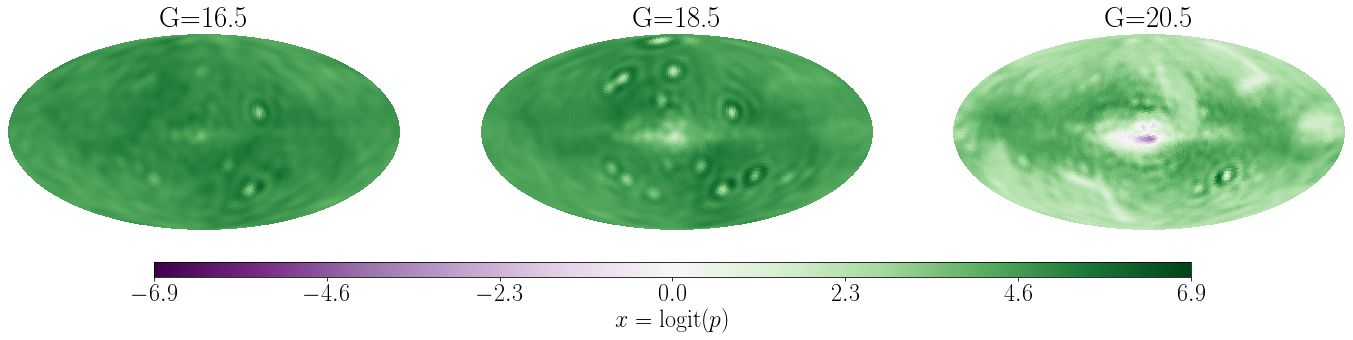

In [157]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    hp.mollview(logit(prob_selection[i]), nest=True, min=minmax[0],max=minmax[1], notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.1, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

## Load in Data

In [17]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

In [18]:
mag_res = 0.1;
M_bins = np.arange(Mlims[0], Mlims[1], mag_res)

data_M=int((Mlims[1]-Mlims[0])/mag_res + eps);
data_C=1
data_nside = pow(2,7)
data_res=(data_M, data_C, hp.nside2npix(data_nside))
sample="astrometry"; file="Gres10hpx7"; box={};
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_{file}.h', 'r') as hf:
    box['n'] = np.zeros(data_res, dtype=np.int64)
    box['k'] = np.zeros(data_res, dtype=np.int64)

    Midx = hf['magnitude'][...] - int(Mlims[0]/mag_res + eps)
    Cidx = np.zeros(len(Midx), dtype=np.int64)
    Pidx = hf['position'][...]
    in_range = (Midx>-1)&(Midx<data_M)&(Cidx>-1)&(Cidx<data_C)
    for key in ['n','k']:
        box[key][Midx[in_range], Cidx[in_range], Pidx[in_range]] = hf[key][...][in_range]
print(box['n'].shape)

(170, 1, 196608)


In [19]:
box['n']= _downgrade(box['n'])
box['k']= _downgrade(box['k'])
M_bins = np.linspace(Mlims[0], Mlims[1]+1e-5, M)

$$ P( k | n, p ) = \mathrm{Binomial}( k ; n, p) $$

$$ P( p | k, n ) = \frac{\mathrm{Binomial}( k ; n, p) \, \mathrm{Beta}(p | \alpha, \beta)}{\int \mathrm{d}p\, \mathrm{Binomial}( k ; n, p) \,\mathrm{Beta}(p | \alpha, \beta)} \\
= \mathrm{Beta}(p | \alpha+k, \beta+n-k)$$

$$ \mathbb{E}[p] = (\alpha + k)/(\alpha + \beta + n) $$

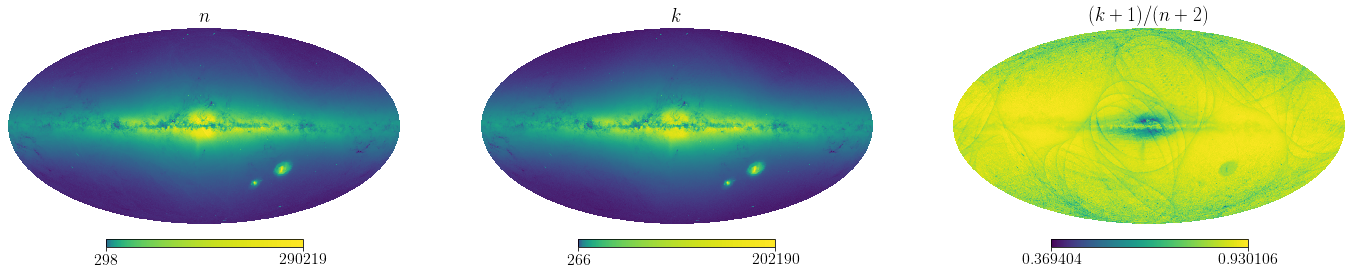

In [21]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))

minmax = np.min(np.sum(box['n'], axis=(0,1))), np.max(np.sum(box['n'], axis=(0,1)))

plt.sca(axes[0])
hp.mollview(np.sum(box['n'], axis=(0,1)), nest=True, notext=True, norm='log',# min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$n$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[1])
hp.mollview(np.sum(box['k'], axis=(0,1)), nest=True, notext=True, norm='log',#min=minmax[0], max=minmax[1],
            coord=['C','G'], title=r'$k$', cmap='viridis', hold=True, cbar=True, xsize=2000)

plt.sca(axes[2])
hp.mollview((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2), nest=True, notext=True, norm='log',
            coord=['C','G'], title=r'$(k+1)/(n+2)$', cmap='viridis', hold=True, cbar=True, xsize=2000)

## Evaluate Selection Function

$$ x = \sum_{l=0}^{l_\mathrm{max}} \, \sum_{m=-l}^{l} a_{lm} \,Y_{lm} $$

$$ p = \mathrm{expit}(x) $$

In [13]:
g = [16.5,18.5,20.5]
prob_selection = np.zeros((3,hp.nside2npix(32)))
for i in range(3):
    ra, dec = hp.pix2ang(32,np.arange(hp.nside2npix(32)),nest=True, lonlat=True)
    coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g[i]*np.ones(ra.shape)})

    prob_selection[i] = ast_sf(coords, chunksize=1000)

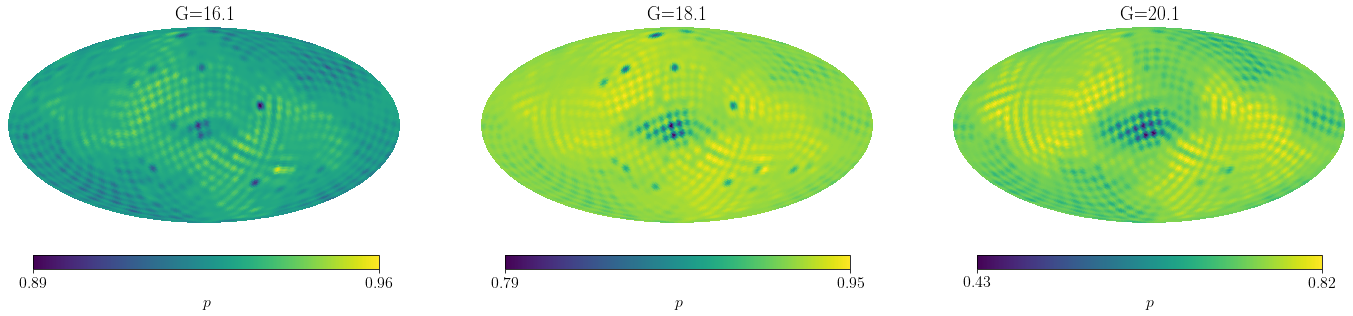

In [65]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
for i in range(3):
    plt.sca(axes[i])
    minmax = [np.round(np.min(prob_selection[i]), decimals=2), np.round(np.max(prob_selection[i]), decimals=2)]
    hp.mollview(prob_selection[i], nest=True, min=minmax[0], max=minmax[1], cbar=False, notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='viridis', hold=True, unit=r'$p$', xsize=2000)
    
    ax = fig.add_axes([i*0.273+0.14, 0.1, 0.2, 0.04]); 
    norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
    im = plt.cm.ScalarMappable(norm=norm, cmap='viridis'); im.set_array([])
    cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[1]])
    cbar.set_label(r'$p$', fontsize=16)
    
#plt.savefig('figs/%s_p_3hpx.png' % run_name, bbox_inches='tight', dpi=200)

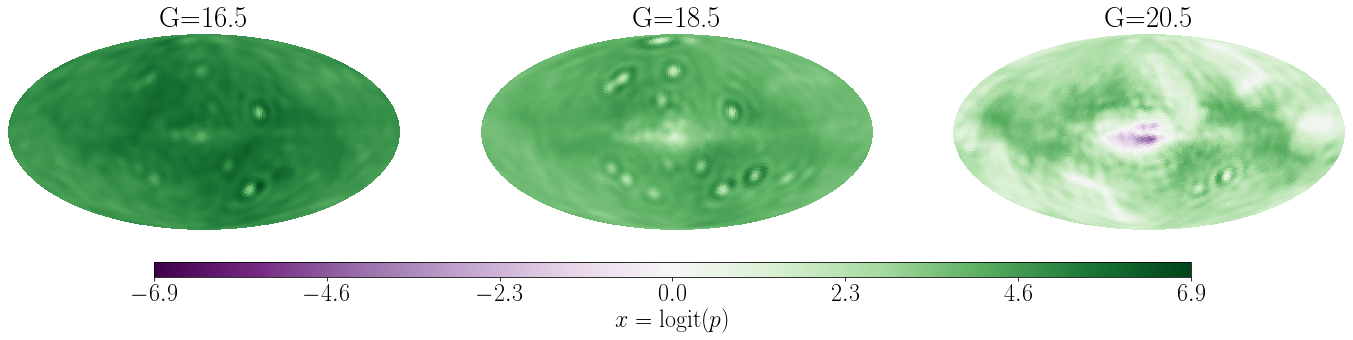

In [13]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    hp.mollview(logit(prob_selection[i]), nest=True, min=minmax[0],max=minmax[1], notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.1, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

#plt.savefig('figs/ast/%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Beta distribution tests of Comparison

In [20]:
g = [16.51,18.51,20.51]

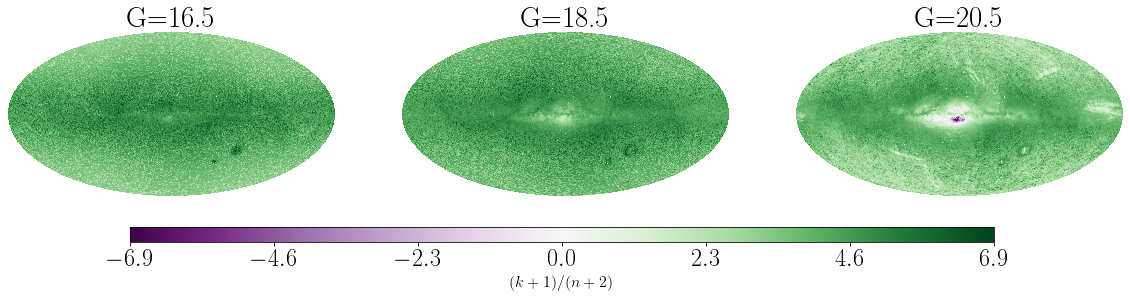

In [21]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    expected = (box['k'][g_idx,0]+1)/(box['n'][g_idx,0]+2)
    hp.mollview(logit(expected), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$(k+1)/(n+2)$', fontsize=16)

plt.savefig('figs/ast/%s_expected-x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Load in full pixel selection function

In [22]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['x'] = f['x'][...]
    sf_box['b'] = f['b'][...]
    sf_box['z'] = f['z'][...]
    M_bins = np.linspace(f['Mlim'][0], f['Mlim'][1]+0.1, M+1)
    print(f['Mlim'][...])

[ 5.  21.9]


In [81]:
gtest = 19.9
ast_sf.lengthscale_c = 400

ra, dec = hp.pix2ang(32,np.arange(hp.nside2npix(32)),nest=True, lonlat=True)
coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':gtest*np.ones(ra.shape)})
prob_selection = ast_sf(coords, chunksize=1000)

g_idx = np.sum(M_bins<gtest)-1
np.mean(np.abs(logit(prob_selection) - sf_box['x'][g_idx,0]))

0.14574991120150013

In [ ]:
0.14576412653691742

In [88]:
ast_sf.Mcenters = (M_bins[1:] + M_bins[:-1])/2
ast_sf._inv_KMM = np.linalg.inv(ast_sf.covariance_kernel(ast_sf.Mcenters, ast_sf.Mcenters, lengthscale=0.3) + 1e-15*np.eye(M))

In [85]:
sf_box['z'].shape

(4093, 85, 1)

In [84]:
KMM

array([[1.        , 0.8007374 , 0.41111229, ..., 0.        , 0.        ,
        0.        ],
       [0.8007374 , 1.        , 0.8007374 , ..., 0.        , 0.        ,
        0.        ],
       [0.41111229, 0.8007374 , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.8007374 ,
        0.41111229],
       [0.        , 0.        , 0.        , ..., 0.8007374 , 1.        ,
        0.8007374 ],
       [0.        , 0.        , 0.        , ..., 0.41111229, 0.8007374 ,
        1.        ]])

In [79]:
KmM = ast_sf.covariance_kernel(np.array([gtest]), ast_sf.Mcenters, lengthscale=ast_sf.lengthscale_m)
KcC = ast_sf.covariance_kernel(np.array([0.]), ast_sf.Ccenters, lengthscale=500)

In [74]:
ast_sf.lengthscale_m

0.3

In [60]:
(KmM @ ast_sf._inv_KMM).shape

(1, 85)

In [65]:
(KmM @ ast_sf._inv_KMM) @ ast_sf.b

array([[[ 4.13283993]],

       [[-1.05929785]],

       [[-0.26483461]],

       ...,

       [[-0.15143906]],

       [[ 0.06935559]],

       [[ 0.0248709 ]]])

In [80]:
(KcC @ ast_sf._inv_KCC)

array([[0.9999995]])

In [70]:
g_idx

74

In [72]:
np.argwhere(np.abs(KmM @ ast_sf._inv_KMM)[0]>0.1)

array([[74]])

In [52]:
ast_sf.Mcenters

array([ 5.1,  5.3,  5.5,  5.7,  5.9,  6.1,  6.3,  6.5,  6.7,  6.9,  7.1,
        7.3,  7.5,  7.7,  7.9,  8.1,  8.3,  8.5,  8.7,  8.9,  9.1,  9.3,
        9.5,  9.7,  9.9, 10.1, 10.3, 10.5, 10.7, 10.9, 11.1, 11.3, 11.5,
       11.7, 11.9, 12.1, 12.3, 12.5, 12.7, 12.9, 13.1, 13.3, 13.5, 13.7,
       13.9, 14.1, 14.3, 14.5, 14.7, 14.9, 15.1, 15.3, 15.5, 15.7, 15.9,
       16.1, 16.3, 16.5, 16.7, 16.9, 17.1, 17.3, 17.5, 17.7, 17.9, 18.1,
       18.3, 18.5, 18.7, 18.9, 19.1, 19.3, 19.5, 19.7, 19.9, 20.1, 20.3,
       20.5, 20.7, 20.9, 21.1, 21.3, 21.5, 21.7, 21.9])

In [42]:
M_bins[g_idx]

19.79999999999995

In [14]:
i=1
print(np.std(sf_box['z']))
for j in range(1,jmax+1):
    print(j, np.std(sf_box['z'][i:i+hp.nside2npix(j)]))
    i+=hp.nside2npix(j)
np.min(sf_box['z']), np.max(sf_box['z'])

1.12521788514937
1 1.128228933469668
2 1.6577152359043608
3 1.3693672450490606
4 1.2707208372795131


(-20.86383470713466, 20.335834449553737)

In [38]:
i=1
print(np.std(sf_box['z']))
for j in range(1,jmax+1):
    print(j, np.std(sf_box['z'][i:i+hp.nside2npix(j)]))
    i+=hp.nside2npix(j)
np.min(sf_box['z']), np.max(sf_box['z'])

0.8341538753799745
1 1.0120508747998487
2 1.0250735214471771
3 1.047575435059787
4 1.025310427586729


(-22.685022659244638, 13.544415263963362)

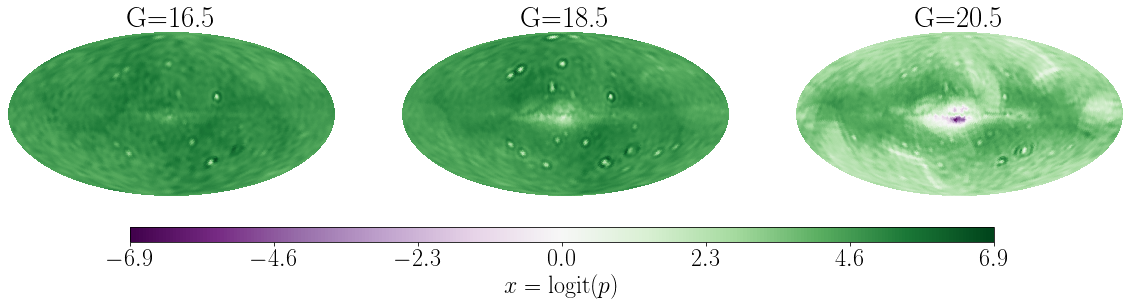

In [23]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    hp.mollview(sf_box['x'][g_idx,0], nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

plt.savefig('figs/ast/%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

## P-value of k

$$ p_\mathrm{value} \sim U[I_{k-1}, I_k]$$

$$ I_k = \sum_{j=0}^{k} \mathrm{Binomial}(\,j\,;\, n,\,p) $$

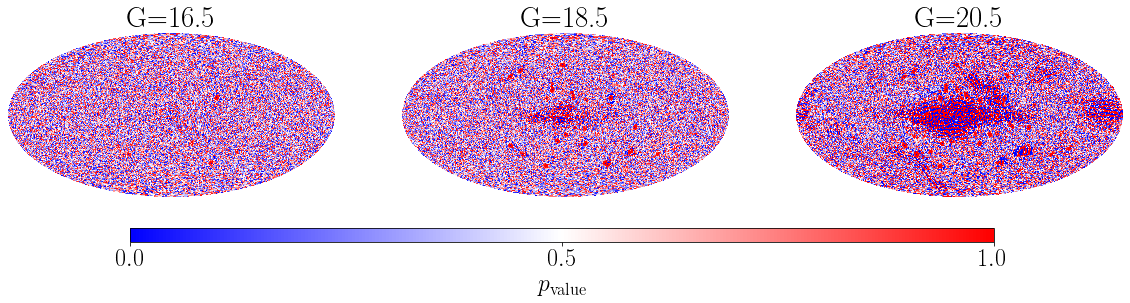

In [24]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[0.,1.]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0.5, minmax[1]])
cbar.set_label(r'$p_\mathrm{value}$', fontsize=24)

plt.savefig('figs/ast/%s_binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

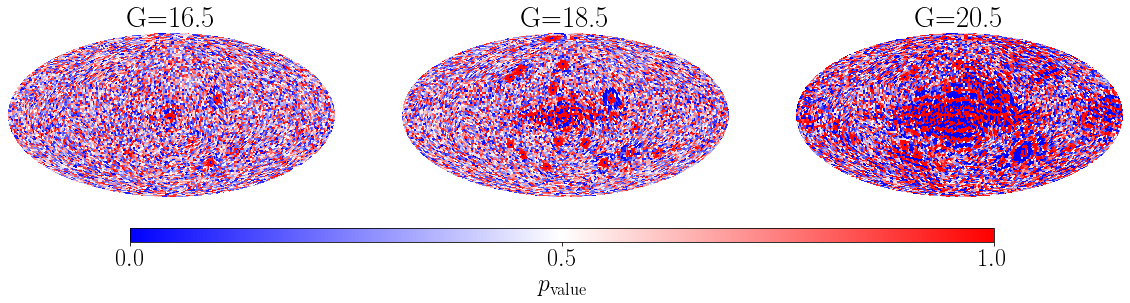

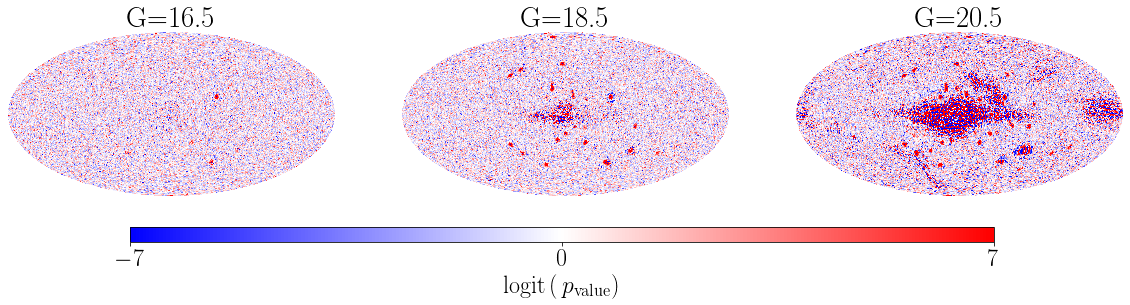

In [25]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(logit(pvals), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$\mathrm{logit}\left(\,p_\mathrm{value}\right)$')

plt.savefig('figs/ast/%s_logit-binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

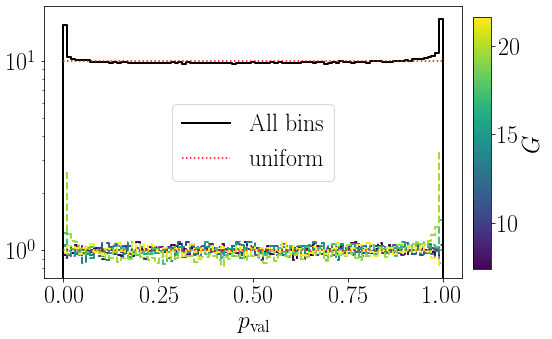

In [26]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    plothist(pvals, bins=np.linspace(0,1,100), density=True,
            color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--')
    

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
plothist(pvals.flatten(), bins=np.linspace(0,1,100), label='All bins', 
        color='k', linewidth=2, density=True, count=len(pvals.flatten())/10)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=24)


plt.plot([0,1], [1,1], ':r', label='uniform')
plt.plot([0,1], [10,10], ':r')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='center')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)
plt.savefig('figs/ast/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

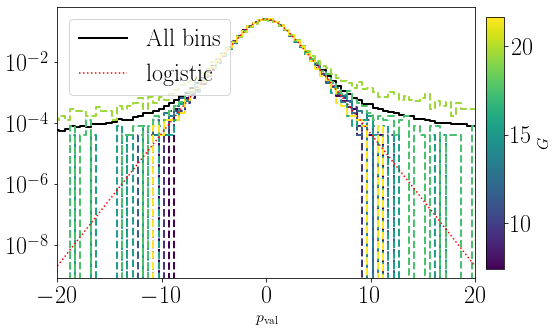

In [27]:
g = np.arange(7.5,21.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
minmax = np.round(np.min(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)-1.,\
         np.round(np.max(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)+1.
bins = np.arange(minmax[0], minmax[1]+1e-10, 0.5)
    
pvals[pvals==0.] = expit(minmax[0]+0.05); pvals[pvals==1.] = expit(minmax[1]-0.05)
plothist(logit(pvals.flatten()), bins=bins, label='All bins',
        color='k', linewidth=2, density=True, count=len(pvals.flatten()))

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    pvals[logit(pvals)<minmax[0]] = expit(minmax[0]+0.05); 
    pvals[logit(pvals)>minmax[1]] = expit(minmax[1]-0.05)
    plothist(logit(pvals), bins=bins,
        color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--', density=True)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)

plt.xlim(-20,20)

x = np.linspace(-20,20,100)
plt.plot(x, scipy.stats.logistic.pdf(x), ':r', label='logistic')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

plt.savefig('figs/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

# Multi-panel figure

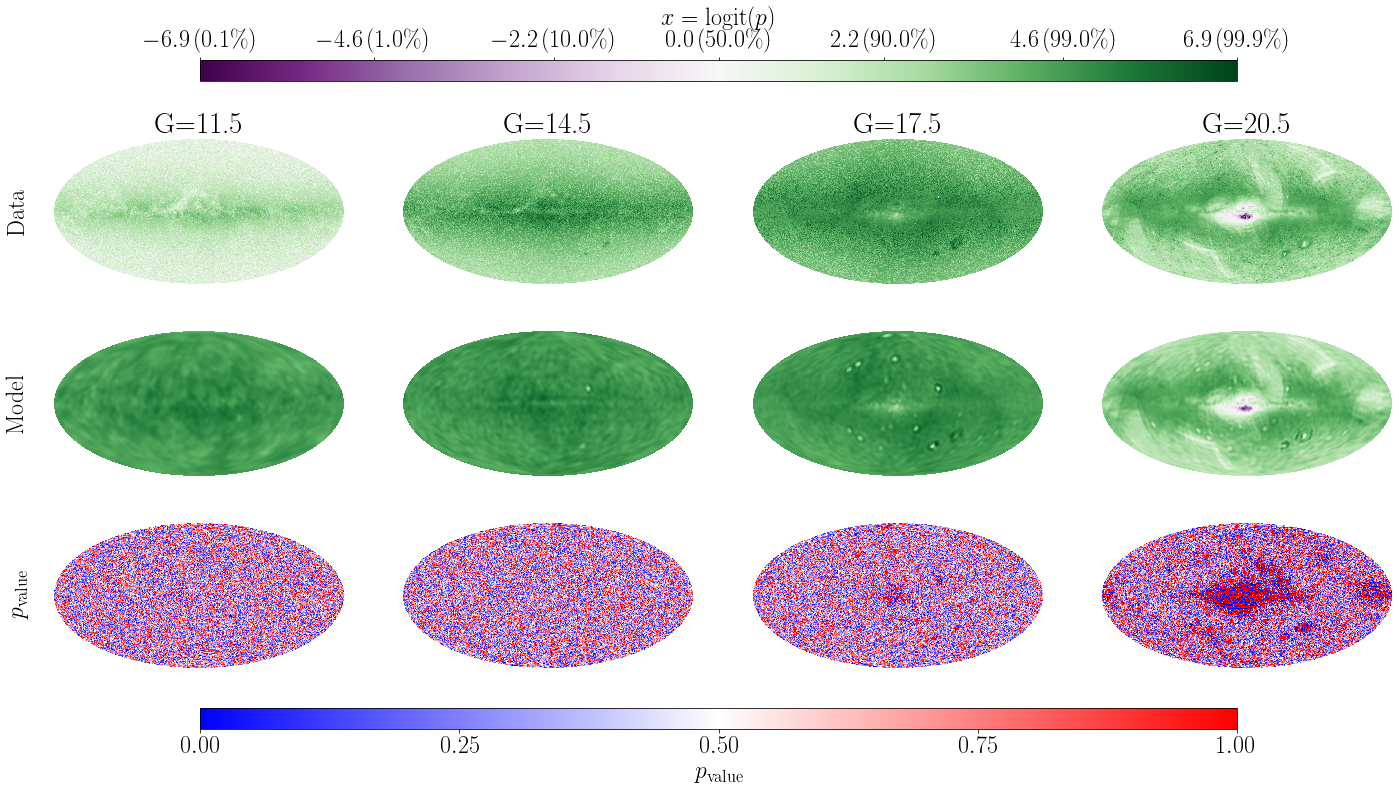

In [28]:
fig, axes = plt.subplots(3,4,figsize=(24,10))

g = [11.5,14.5,17.5,20.5]

minmax=[np.log(1/999),np.log(0.999/0.001)]
p=np.array([0.001,0.01,0.1,0.5,0.9,0.99,0.999]); ticks=np.log(p/(1-p))
tick_labels = [rf"${ticks[i]:.1f}\,({p[i]*100:.1f}\%)$" for i in range(len(p))]

for i in range(4):
    plt.sca(axes[0,i])
    g_idx = np.sum(M_bins<g[i])-1
    expected = (box['k'][g_idx,0]+1)/(box['n'][g_idx,0]+2)
    hp.mollview(logit(expected), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
    if i==0: plt.text(-2.5,0.,r'Data',ha='center', va='center', rotation='vertical')
# ax = fig.add_axes([0.21, 0.75, 0.6, 0.04]); 
# norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
# im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
# cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=ticks)
# cbar.set_ticklabels(tick_labels)
# cbar.set_label(r'$(k+1)/(n+2)$')

for i in range(4):
    plt.sca(axes[1,i])
    g_idx = np.sum(M_bins<g[i])-1
    hp.mollview(sf_box['x'][g_idx,0], nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='', cmap='PRGn', hold=True, cbar=False, xsize=2000)
    if i==0: plt.text(-2.5,0.,r'Model',ha='center', va='center', rotation='vertical')
    
ax = fig.add_axes([0.21, 0.95, 0.6, 0.03]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label(r'$x = \mathrm{logit}(p)$')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')


minmax=[0.,1.]
for i in range(4):
    plt.sca(axes[2,i])
    g_idx = np.sum(M_bins<g[i])-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,0], box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,0]-1, box['n'][g_idx,0], expit(sf_box['x'][g_idx,0]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='', cmap='bwr', hold=True, cbar=False, xsize=2000)
    if i==0: plt.text(-2.5,0.,r'$p_\mathrm{value}$',ha='center', va='center', rotation='vertical')

ax = fig.add_axes([0.21, 0.05, 0.6, 0.03]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(0,1.01,0.25))
cbar.set_label(r'$p_\mathrm{value}$', fontsize=24)

plt.savefig('figs/ast/%s_3x4hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Magnitude distribution

In [29]:
ix=2
g = np.array([18])
c = Source(l=np.zeros(len(g))+l[ix], b=np.zeros(len(g))+b[ix], unit='deg', frame='galactic', photometry={'gaia_g':g})
ast_sf(c)

NameError: name 'l' is not defined

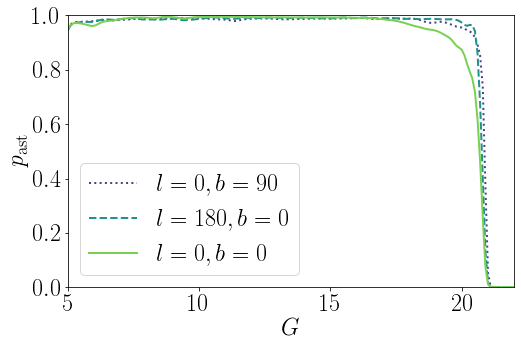

In [30]:
g = np.linspace(5.,22.,171)

l = [0., 180., 0.]
b = [90., 0., 0.]
colors = [cm.viridis(0.2), cm.viridis(0.5), cm.viridis(0.8)]
linestyles = [':','--','-']

plt.figure(figsize=(8,5))

for ix in range(len(l)):
    coords = Source(l=np.zeros(len(g))+l[ix], b=np.zeros(len(g))+b[ix], unit='deg', frame='galactic', 
                    photometry={'gaia_g':g})
    
    plt.plot(g, ast_sf(coords), c=colors[ix], linestyle=linestyles[ix],
            label=fr'$l={l[ix]:.0f}, b={b[ix]:.0f}$', linewidth=2)
    
plt.xlim(g[0], g[-1]); plt.ylim(0,1)
plt.xlabel(r'$G$'); plt.ylabel(r'$p_\mathrm{ast}$')
plt.legend(loc='lower left')

plt.savefig(f'figs/ast/{run_name}_pmag.png' , bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

In [ ]:
g = [16.5,18.5,20.5]
prob_selection = np.zeros((3,hp.nside2npix(32)))
for i in range(3):
    ra, dec = hp.pix2ang(32,np.arange(hp.nside2npix(32)),nest=True, lonlat=True)
    coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':g[i]*np.ones(ra.shape)})

    prob_selection[i] = ast_sf(coords, chunksize=1000)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(24,5))
for i in range(3):
    plt.sca(axes[i])
    minmax = [np.round(np.min(prob_selection[i]), decimals=2), np.round(np.max(prob_selection[i]), decimals=2)]
    hp.mollview(prob_selection[i], nest=True, min=minmax[0], max=minmax[1], cbar=False, notext=True,
                coord=['C','G'], title='G=%.1f'%g[i], cmap='viridis', hold=True, unit=r'$p$', xsize=2000)
    
    ax = fig.add_axes([i*0.273+0.14, 0.1, 0.2, 0.04]); 
    norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
    im = plt.cm.ScalarMappable(norm=norm, cmap='viridis'); im.set_array([])
    cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], minmax[1]])
    cbar.set_label(r'$p$', fontsize=16)
    
#plt.savefig('figs/%s_p_3hpx.png' % run_name, bbox_inches='tight', dpi=200)

In [14]:
raise KeyboardInterrupt("Don't need to run this")
ra, dec = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), nest=True, lonlat=True)

g = np.linspace(5,22,500)

rr, gg = np.meshgrid(ra, g)
dd, gg = np.meshgrid(dec, g)

prob_selection = np.zeros((len(ra), g.shape[0]))

ast_sf._g_min = np.min(g)
ast_sf._g_max = np.max(g)

chunksize=1000
for ii in tqdm.tqdm_notebook(range(ra.shape[0]//chunksize + 1)):
    coords = Source(rr[:,ii*chunksize:(ii+1)*chunksize]*units.deg, 
                    dd[:,ii*chunksize:(ii+1)*chunksize]*units.deg, frame='icrs', 
                    photometry={'gaia_g':gg[:,ii*chunksize:(ii+1)*chunksize]})
    prob_selection[ii*chunksize:(ii+1)*chunksize] = ast_sf(coords, chunksize=1000)

KeyboardInterrupt: Don't need to run this

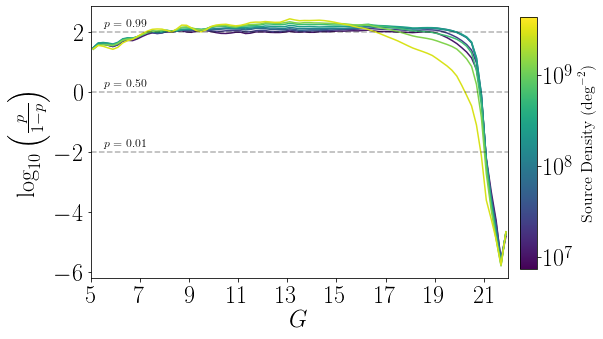

In [31]:
source_count = np.sum(box['n'], axis=(0,1))
area = hp.nside2pixarea(64)
source_density = source_count/area
sd_bins = np.logspace(np.log10(np.min(source_density)), np.log10(np.max(source_density)), 9)

cmap=cm.viridis

fig, ax = plt.subplots(1,1,figsize=(8,5))
for i, sd in enumerate(sd_bins[:-1]):
    pix = (source_density>sd_bins[i])&(source_density<sd_bins[i+1])
    
    sd = np.sqrt(sd_bins[i]*sd_bins[i+1])
    
    mean = np.sum(sf_box['x'][:,0,:].T[pix].T* source_count[pix], axis=1) /np.sum(source_count[pix])
    plt.plot(ast_sf.Mcenters, mean / np.log(10),
            c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))
    
#     mean = np.sum(logit(prob_selection.T[pix]) * source_count[pix,None], axis=0) /np.sum(source_count[pix])
#     plt.plot(g, mean / np.log(10),
#             c=cmap((np.log10(sd)-np.log10(sd_bins[0]))/(np.log10(sd_bins[-1])-np.log10(sd_bins[0]))))
    
plt.xlabel(r'$G$'); plt.ylabel(r'$\mathrm{log}_{10}\left(\frac{p}{1-p}\right)$')
plt.xlim(5, 22)
ax.set_xticks(np.arange(5,21.1,2.))

for p in [1e-2,0.5,1-1e-2]:
    xlim = ax.get_xlim()
    plt.plot(xlim, [np.log10(p/(1-p)), np.log10(p/(1-p))], '--k', alpha=0.3)
    if p>0.005: plt.text(5.5, np.log10(p/(1-p))+0.2, r'$p = {:.2f}$'.format(p), fontsize=12)
    else: plt.text(5.5, np.log10(p/(1-p))+0.2, r'$10^{%d}$' % np.log10(p), fontsize=12)

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
cbar = add_log_cbar(cbar_ax, cmap=cmap, vmin=sd_bins[0], vmax=sd_bins[-1],
                   ticks=10**(np.arange(5,10)), tick_labels=[r'$10^%d$' % i for i in np.arange(5,10)] )

cbar.set_label(r'Source Density $(\mathrm{deg}^{-2})$', fontsize=16)

plt.savefig('figs/ast/%s_x-vs-mag_meansd.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

In [25]:
from astropy.coordinates import SkyCoord

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


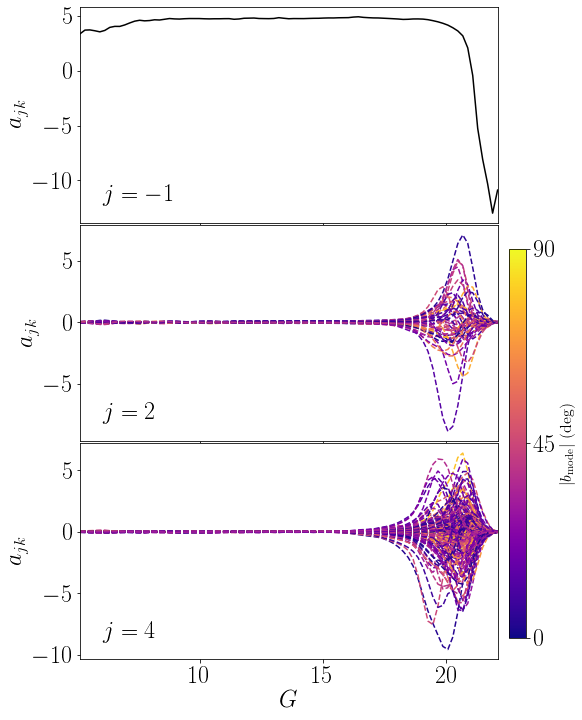

In [31]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

g = M_bins + (M_bins[1]-M_bins[0])/2
cmap = cm.plasma
#logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

j_vals = [-1,2,4]
sigma = [-0.81489922, -2.55429039]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(j_vals),sigma[1]))
imode=0

for i, _j in enumerate(j_vals):
    plt.sca(axes[i])
    if _j==-1:
        plt.plot(g, sf_box['b'][imode,:,0], '-k')#, color=cmap((_m+_l)/(2*_l)))
        imode+=1
    else:
        ra,dec = hp.pix2ang(_j, np.arange(hp.nside2npix(_j)), nest=False, lonlat=True)
        c = SkyCoord(ra, dec, unit='deg', frame='icrs')
        l = c.galactic.l.deg
        b = c.galactic.b.deg
        for _m in range(hp.nside2npix(_j)):
            plt.plot(g, sf_box['b'][imode,:,0], '--', color=cmap((np.abs(b[_m]))/90))
            imode+=1

    #plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')

    ylim = axes[i].get_ylim()
    plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
    plt.ylabel(r'$a_{jk}$')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.45])
norm = matplotlib.colors.Normalize(vmin=0,vmax=90)
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,45,90])
cbar.set_label(r'$|b_\mathrm{mode}|$ (deg)', fontsize=16)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

plt.savefig('figs/ast/%s_b-vs-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

# Using GP on b

In [42]:
g = np.linspace(5.5,22,500)
col = np.zeros(len(g))

# Contstruct covariance kernel for new positions.
KmM = ast_sf.covariance_kernel(g, ast_sf.Mcenters, lengthscale=ast_sf.lengthscale_m)
KcC = ast_sf.covariance_kernel(col, ast_sf.Ccenters, lengthscale=ast_sf.lengthscale_c)

# Estimate alm using Gaussian Process
_b = np.sum ( ((KmM @ ast_sf._inv_KMM) @ ast_sf.b) * (KcC @ ast_sf._inv_KCC)[None, :,:] , axis=2)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


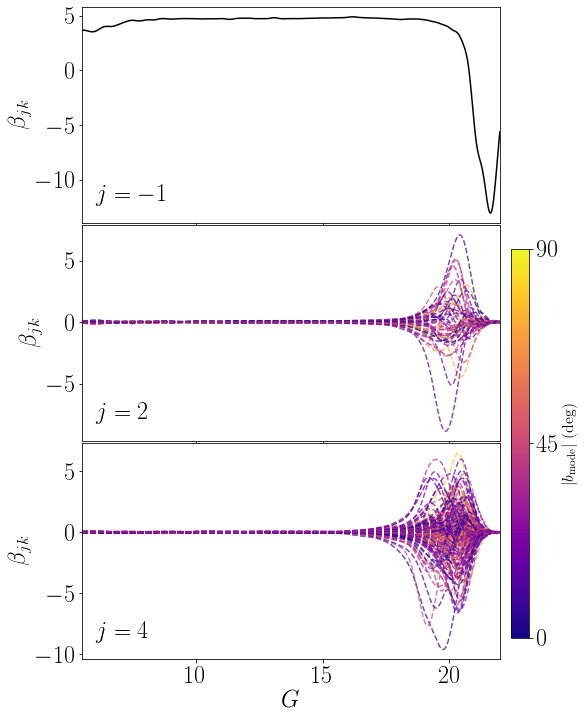

In [46]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

cmap = cm.plasma
#logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

j_vals = [-1,2,4]
sigma = [-0.67227718, -2.35088459]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(j_vals),sigma[1]))
imode=0

for i, _j in enumerate(j_vals):
    plt.sca(axes[i])
    if _j==-1:
        #plt.plot(g, _b[imode]/pychisel.sigma[imode], '-k')#, color=cmap((_m+_l)/(2*_l)))
        plt.plot(g, _b[imode], '-k')#, color=cmap((_m+_l)/(2*_l)))
        imode+=1
    else:
        ra,dec = hp.pix2ang(_j, np.arange(hp.nside2npix(_j)), nest=False, lonlat=True)
        c = SkyCoord(ra, dec, unit='deg', frame='icrs')
        l = c.galactic.l.deg
        b = c.galactic.b.deg
        for _m in range(hp.nside2npix(_j)):
            #plt.plot(g, _b[imode]/pychisel.sigma[imode], '--', color=cmap((np.abs(b[_m]))/90))
            plt.plot(g, _b[imode], '--', color=cmap((np.abs(b[_m]))/90), alpha=0.7)
            imode+=1

    #plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')

    ylim = axes[i].get_ylim()
    plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
    plt.ylabel(r'$\beta_{jk}$')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.45])
norm = matplotlib.colors.Normalize(vmin=0,vmax=90)
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,45,90])
cbar.set_label(r'$|b_\mathrm{mode}|$ (deg)', fontsize=16)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

plt.savefig('figs/ast/%s_GP_b-vs-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

In [22]:
i=1; jmax=3
print(np.std(sf_box['z']))
for j in range(1,jmax+1):
    print(j, np.std(sf_box['z'][i:i+hp.nside2npix(j)]))
    i+=hp.nside2npix(j)
np.min(sf_box['z']), np.max(sf_box['z'])

1.9288753239146883
1 1.3360949690326411
2 1.6536689269617644
3 2.5174489449731294


(-41.44098975957966, 35.52328458168333)

In [24]:
i=1; jmax=3
print(np.std(sf_box['z']))
for j in range(1,jmax+1):
    print(j, np.std(sf_box['z'][i:i+hp.nside2npix(j)]))
    i+=hp.nside2npix(j)
np.min(sf_box['z']), np.max(sf_box['z'])

0.9873003919124046
1 0.9793631014911898
2 0.954838416844449
3 1.0088483896991762


(-7.988395233899271, 5.49746032229341)

In [26]:
i=1; jmax=3
print(np.std(sf_box['z']))
for j in range(1,jmax+1):
    print(j, np.std(sf_box['z'][i:i+hp.nside2npix(j)]))
    i+=hp.nside2npix(j)
np.min(sf_box['z']), np.max(sf_box['z'])

1.2622192583510579
1 1.1928264827597448
2 1.2243809894364062
3 1.6115920966613821


(-20.193644826780883, 21.781297596609107)

## Needlet std

In [49]:
sf_box = {}
file = "/data/asfe2/Projects/astrometry/PyOutput/chisquare_astrometry_jmax3_nside16_M21_C1_l0.3_B2.0_ncores10mp_lbfgsb_scipy_results.h5"
file = "/data/asfe2/Projects/astrometry/PyOutput/chisquare_astrometry_jmax0_nside16_M21_C1_l0.3_B2.0_ncores10mp_lbfgsb_scipy_results.h5"
file = "/data/asfe2/Projects/astrometry/PyOutput/chisquare_astrometry_jmax0_nside16_M214_C1_l0.3_B2.0_ncores10mp_lbfgsb_scipy_results.h5"
with h5py.File(file, 'r') as f:
    sf_box['z'] = f['z'][...]

In [50]:
np.std(sf_box['z'])

7.30540656588452

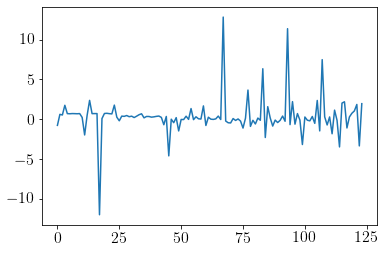

In [51]:
plt.plot(sf_box['z'][0,:,0])

'0-1-2'

In [ ]:
str([0,1,2]).replace(', ','-').replace('[','').replace

In [55]:
''.replace?

Object `replace` not found.


In [ ]:
''.replace

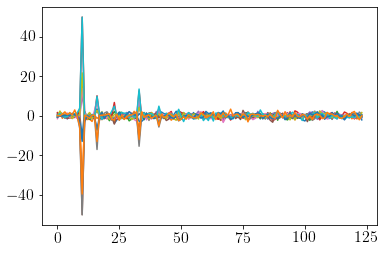

In [48]:
plt.plot(sf_box['z'][1:13,:,0].T)

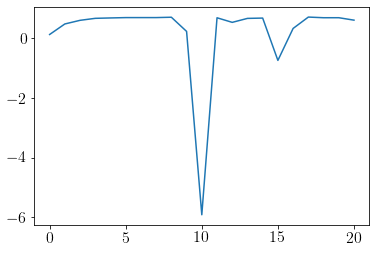

In [32]:
plt.plot(sf_box['z'][0,:,0])

In [34]:
sf_box['z'].shape

(13, 21, 1)

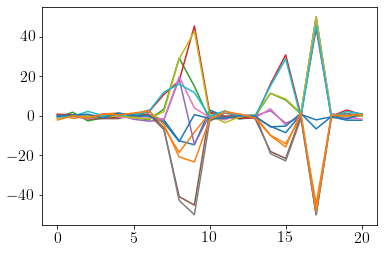

In [33]:
plt.plot(sf_box['z'][1:13,:,0].T)

In [37]:
eps=1e-5
M = 21; Mlims = [2,23]; C = 1; Clims = [-100,100]; nside=16; jmax=-1; B=2.

colour=False
mag_res = 0.1;
M_bins = np.arange(Mlims[0], Mlims[1], mag_res)

col_res = 199;
C_bins = np.arange(Clims[0], Clims[1], col_res)

data_M=int((Mlims[1]-Mlims[0])/mag_res + eps);
data_C=int((Clims[1]-Clims[0])/col_res + eps);
data_nside = pow(2,7)
data_res=(data_M, data_C, hp.nside2npix(data_nside))
print('data_res: ', data_res)
sample="astrometry"; file="Gres10hpx7"
box={};
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_{file}.h', 'r') as hf:
    box['n'] = np.zeros(data_res, dtype=np.int64)
    box['k'] = np.zeros(data_res, dtype=np.int64)

    Midx = hf['magnitude'][...] - int(Mlims[0]/mag_res + eps)
    try: Cidx = hf['colour'][...] - int(Clims[0]/mag_res + eps)
    except KeyError: Cidx = np.zeros(len(Midx), dtype=np.int64)
    Pidx = hf['position'][...]
    in_range = (Midx>-1)&(Midx<data_M)&(Cidx>-1)&(Cidx<data_C)
    for key in ['n','k']:
        box[key][Midx[in_range], Cidx[in_range], Pidx[in_range]] = hf[key][...][in_range]
print(box['n'].shape)

data_res:  (210, 1, 196608)
(210, 1, 196608)


In [40]:
n = np.sum(box['n'], axis=(1,2))
k = np.sum(box['k'], axis=(1,2))

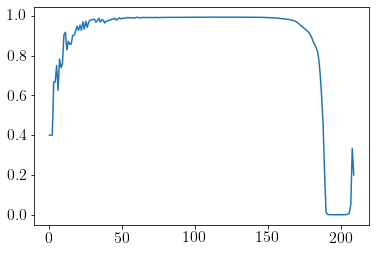

In [42]:
plt.plot((k+1)/(n+2))

# Convergence curve

In [40]:
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    likelihood = f['optimum_lnp_history'][...]

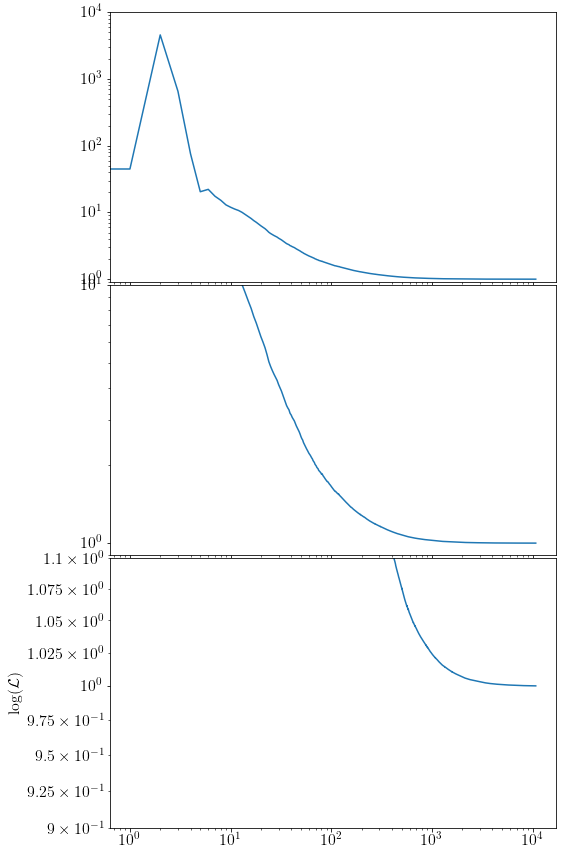

In [52]:
fig, axes = plt.subplots(3,1,figsize=(8,15), sharex=True)

for i in range(3):
    plt.sca(axes[i])
    plt.plot((likelihood/likelihood[-1]))
    plt.yscale('log'); 
    
plt.sca(axes[0]); plt.ylim(0.9,1e4)
plt.sca(axes[1]); plt.ylim(0.9,10)
plt.sca(axes[2]); plt.ylim(0.9,1.1)
    
plt.xscale('log')
plt.ylabel(r'$\log(\mathcal{L})$')
plt.subplots_adjust(hspace=0.01)

In [14]:
# Import chisel
lengthscale = 0.3
# Calculate lengthscales in units of bins
M_original, C_original = box['k'].shape[:2]
lengthscale_m = lengthscale/((M_bins[1]-M_bins[0])*(M_original/M))
lengthscale_c = lengthscale/((100--100)*(C_original/C))
print(f"lengthscales m:{lengthscale_m} , c:{lengthscale_c}")

sys.path.append('../SelectionFunctionToolkit/')
from SelectionFunctionPython import pyChisel
pychisel = pyChisel(box['k'], box['n'],
                basis_options,"Bad directory",
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m, M = M, Mlim = [M_bins[0], M_bins[-1]],
                lengthscale_c = lengthscale_c, C = C, Clim = [-100, 100],
                nside = nside,
                sparse = True, pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.55429039],
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/StanOutput/',
                stan_model_directory='../SelectionFunctionToolkit/StanModels'
                )

lengthscales m:1.4999999999999987 , c:0.0015
Spherical basis file loaded
85 85
1 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


84.30% sparsity
0.00% sparsity
Incrementing wavelet_u
Incrementing wavelet_un
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [194]:
from numba import njit

@njit
def matrix_multiply(out, b, KM, KC, modes):
    out*=0.

    # Iterate over pixels
    for i, iS in enumerate(modes):
        out[i] += np.dot(np.dot(KM[i], b[iS]), KC[i])

mag = 
color = np.zeros(len(mag))
modes = np.zeros(len(mag), dtype=int)
        
# Contstruct covariance kernel for new positions.
KmM = ast_sf.covariance_kernel(mag, ast_sf.Mcenters, lengthscale=ast_sf.lengthscale_m)
KcC = ast_sf.covariance_kernel(color, ast_sf.Ccenters, lengthscale=ast_sf.lengthscale_c)

b_out = np.zeros(len(modes))
matrix_multiply(b_out, sf_box['b'], (KmM @ ast_sf._inv_KMM), (KcC @ ast_sf._inv_KCC), modes)

# Progress review

In [8]:
M = 85; C = 1; nside=64; jmax=5; B=3.; lengthscale = 0.3
run_name = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_B{B}"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

map_fname = run_name + "_scipy_results.h5"

box={};
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_arr_hpx128.h', 'r') as hf:
    box['n'] = hf['n'][...]
    box['k'] = hf['k'][...]
    M_bins = hf['magbins'][...]
    C_bins = np.array([-100,100])
print("Mag bins:", np.linspace(M_bins[0], M_bins[-1], M+1))
# Calculate lengthscales in units of bins
M_original, C_original = box['k'].shape[:2]
lengthscale_m = lengthscale/((M_bins[1]-M_bins[0])*(M_original/M))
lengthscale_c = lengthscale/((C_bins[1]-C_bins[0])*(C_original/C))
print(f"lengthscales m:{lengthscale_m} , c:{lengthscale_c}")

Mag bins: [ 5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6
  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4
 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2
 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.
 16.2 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8
 19.  19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6
 21.8 22. ]
lengthscales m:1.5000000000000053 , c:0.0015


In [9]:
ncores=50
file_root = f"chisquare_jmax{jmax}_nside{nside}_M{M}_C{C}_l{lengthscale}_B{B}_ncores{ncores}mp_lbfgsb"
print(file_root)
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}

# Import chisel
from SelectionFunctionPython import pyChisel
pychisel = pyChisel(box['k'], box['n'],
                basis_options,file_root,
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [-0.81489922, -2.55429039],
                Mlim = [M_bins[0], M_bins[-1]],
                Clim = [C_bins[0], C_bins[-1]],
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/PyOutput/',
                stan_model_directory='../SelectionFunctionToolkit/StanModels/'
                )

chisquare_jmax5_nside64_M85_C1_l0.3_B3.0_ncores50mp_lbfgsb
Spherical basis file loaded
85 85
1 1


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionToolkit/StanModels/wavelet_magnitude_colour_position_sparse


84.30% sparsity
0.00% sparsity
Incrementing wavelet_u
Incrementing wavelet_un
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [13]:
with h5py.File('/data/asfe2/Projects/astrometry/PyOutput/chisquare_jmax5_nside64_M85_C1_l0.3_B3.0_ncores50mp_lbfgsb_latest.h', 'r') as hf:
    pychisel.optimum_z = hf[list(hf.keys())[0]][...]

In [18]:
pychisel._generate_args(sparse=True)

In [19]:
pychisel.optimum_b, pychisel.optimum_x = pychisel._get_bx(pychisel.optimum_z)

MemoryError: Unable to allocate memory to append item

In [ ]:
pychisel.file_root

In [ ]:
# Save optimum to h5py
pychisel.optimum_results_file = pychisel.file_root+'_scipy_latest.h5'
pychisel.save_h5(time.time()-tstart)

In [11]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['z'] = f['z'][...]

In [12]:
sf_box['z']

array([ 3.59580759,  4.37523298,  4.72005506, ..., -0.18120334,
       -0.07104145,  0.07492093])

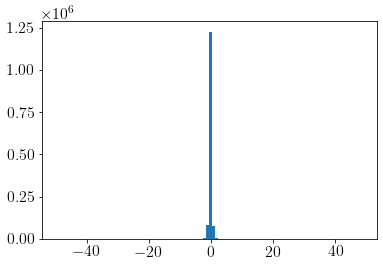

In [14]:
plt.hist(sf_box['z'], bins=100);

In [16]:
np.min(sf_box['z']), np.max(sf_box['z'])

(-49.46559160856522, 48.40764404962245)

# Quadratic

In [46]:
x = np.array([100.15803009,  27.37553242,  12.38453946] )
x = np.array([0.,  40,  88] )
y = np.array([-5.00521665e+08, -4.82599649e+08, -4.77223667e+08])

In [50]:
x = np.array([2.16106239e+04, 1.08552705e+02, 7.07168692e+01, 5.77964194e+01,
 4.81630831e+01, 3.98492691e+01, 3.02258131e+01, 2.13444618e+01,
 1.11534463e+01])
y = np.array([-1.96581079e+09, -4.83741625e+08, -4.79226419e+08, -4.77997347e+08,
 -4.77409914e+08, -4.77014829e+08, -4.76752639e+08, -4.76518863e+08,
 -4.76275156e+08])

In [70]:
M = np.vstack((x**2, x, np.ones(len(x))))[:,-6:]
coeffs = (np.linalg.inv(M @ M.T) @ M) @ y[-6:]

var = -1/(2*coeffs[0])
mu = -coeffs[1]/(2*coeffs[0])
F0 = coeffs[2] + mu**2 / (2*var)
gof = (x[-1]-mu)**2/var

In [73]:
mu

-0.06934467857389552

In [72]:
(mu-x[-1])**2 / var

129959.7769686398

In [65]:
coeffs

array([-5.15913881e+02, -7.15517645e+01, -4.76240647e+08])

In [43]:
M.T @ coeffs

array([-5.00521665e+08, -4.82599649e+08, -4.77223667e+08])

In [30]:
Mfit.shape

(3, 100)

In [32]:
Mfit.T@xfit

array([2.52525253e+07, 3.35016835e+05, 5.00000000e+03])

In [45]:
-1/(2*coeffs[0])

-0.000389753965260604

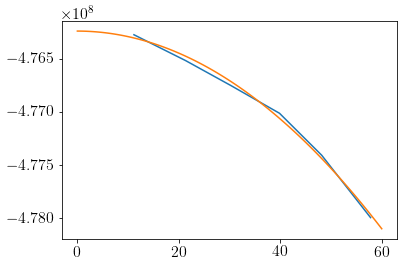

In [74]:
xfit = np.linspace(0,60,100)
Mfit = np.vstack((xfit**2, xfit, np.ones(len(xfit))))
plt.plot(x[-6:],y[-6:])
plt.plot(xfit, Mfit.T@coeffs)

In [17]:
xfit = np.linspace(0,200,100)
xfit[None,:]**(np.arange(3)[:,None])

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.000000

# Test x evaluation

In [81]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['x'] = f['x'][...]
    sf_box['b'] = f['b'][...]
    sf_box['z'] = f['z'][...]
    M_bins = np.linspace(f['Mlim'][0], f['Mlim'][1]+0.1, M+1)

In [82]:
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}
file_root = f"chisquare_astrometry_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}_B{B}_ncores{ncores}"

In [111]:
# Import chisel
from SelectionFunctionPython import pyChisel
pychisel = pyChisel(box['k'], box['n'],
                basis_options,file_root,
                axes = ['magnitude','colour','position'],
                nest = True,
                lengthscale_m = 1.5,
                lengthscale_c = 1.5,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [-0.67227718, -2.35088459],
                Mlim = [5.,22.],
                Clim = [-100,100],
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/',
                stan_output_directory='/data/asfe2/Projects/astrometry/PyOutput/'
                )

../SelectionFunctionToolkit/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical basis file loaded
85 85
1 1
84.33% sparsity
0.00% sparsity
Incrementing wavelet_U
Incrementing wavelet_u
Incrementing wavelet_v
Incrementing cholesky_v_m
Incrementing cholesky_u_m
Incrementing cholesky_v_c
Incrementing cholesky_u_c


In [112]:
pychisel._generate_args(sparse=True)

In [121]:
@njit()
def wavelet_x_sparse(z, M, C, mu, sigma, wavelet, cholesky_m, cholesky_c, x):

    x *= 0.

    for iP, iS, wSP in wavelet:
        for iM, iMsub, wM in cholesky_m:
            for iC, iCsub, wC in cholesky_c:
                x[iP,iM,iC] += wM * z[iS,iMsub,iCsub] * wC * sigma[iS] * wSP

        for iM in range(M):
            for iC in range(C):
                x[iP,iM,iC] += mu[iS] * wSP

    return x
@njit()
def wavelet_xb_sparse(b, wavelet, x):

    x *= 0.

    for iP, iS, wSP in wavelet:
        x[iP] += b[iS] * wSP

    return x
@njit
def wavelet_b_sparse(z, M, C, S, mu, sigma, cholesky_m, cholesky_c, b):

    b *= 0.

    # Iterate over modes which are not sparsified in Y
    for iS in range(S):
        for iM, iMsub, wM in cholesky_m:
            for iC, iCsub, wC in cholesky_c:
                b[iS, iM, iC] += sigma[iS] * wM * z[iS,iMsub,iCsub] * wC;

        for iM in range(M):
            for iC in range(C):
                b[iS,iM,iC] += mu[iS]

    return b

In [118]:
from numba.typed import List
print('Setting cholesky arguments')
wavelet = List(zip(*pychisel.wavelet_args[4:7]))
cholesky_m = List(zip(*pychisel.wavelet_args[7:10]))
cholesky_c = List(zip(*pychisel.wavelet_args[10:13]))

Setting cholesky arguments


In [115]:
print('Get b')
b = np.zeros((pychisel.S, pychisel.M, pychisel.C))
wavelet_b_sparse(sf_box['z'].reshape((pychisel.S, pychisel.M_subspace, pychisel.C_subspace)), pychisel.M, pychisel.C, pychisel.S, *pychisel.wavelet_args[2:4], cholesky_m, cholesky_c, b)

Get b


array([[[ 3.34182142e+00],
        [ 3.59219071e+00],
        [ 3.69832767e+00],
        ...,
        [-1.02657626e+01],
        [-1.32123538e+01],
        [-1.08739964e+01]],

       [[-1.34008038e-02],
        [-1.63066717e-02],
        [-1.02681286e-02],
        ...,
        [ 5.99051743e-02],
        [ 3.76791397e-02],
        [ 8.93571963e-04]],

       [[ 1.99357625e-02],
        [ 1.83848239e-02],
        [ 7.11028409e-03],
        ...,
        [ 1.77338740e-01],
        [-2.23100919e-02],
        [-5.18658437e-02]],

       ...,

       [[ 8.18636610e-04],
        [-2.51159103e-04],
        [ 2.72936096e-04],
        ...,
        [ 2.38692952e-02],
        [-2.86162338e-04],
        [ 1.83392672e-03]],

       [[-7.70749835e-04],
        [-1.62351230e-03],
        [-2.06041461e-03],
        ...,
        [ 1.03576940e-02],
        [-2.56929797e-03],
        [ 3.37591966e-04]],

       [[ 7.52251982e-04],
        [ 4.40080243e-04],
        [ 4.09963240e-06],
        ...,
        

In [116]:
(sf_box['b'] - b)[0,:,0]

array([ 0.00000000e+00,  8.90079085e-02,  1.15463195e-14, -1.52755818e-01,
       -2.10830944e-01,  1.33226763e-15,  7.11477225e-02, -9.28283206e-02,
        1.99134005e-02, -1.13323611e-01,  0.00000000e+00,  2.88207055e-01,
        6.25761602e-02, -1.44622189e-01, -2.45971148e-01,  8.88178420e-16,
        3.31651704e-01, -2.87786848e-02, -6.29498297e-01, -1.17560933e+00,
        0.00000000e+00,  6.13005697e-01,  3.31755585e-02, -4.88878039e-01,
       -5.41620020e-01,  1.77635684e-15,  1.65106180e-01,  1.12761173e-01,
       -2.37721840e-02, -1.18527047e-01,  0.00000000e+00,  2.83724546e-02,
       -5.76178066e-02, -1.75860270e-01, -1.86160296e-01,  8.88178420e-16,
        9.54406093e-02,  3.89469519e-02, -3.97117947e-02, -1.92364403e-02,
        0.00000000e+00, -6.70792207e-02, -4.38214929e-02, -1.17391591e-02,
       -3.04564088e-02,  8.88178420e-16,  2.21711283e-01,  3.24312738e-01,
       -1.24537612e-02, -2.63154364e-01,  0.00000000e+00,  3.49319919e-01,
        1.88765616e-01,  

In [87]:
print('Get x')
x = np.zeros((pychisel.P, pychisel.M, pychisel.C))
wavelet_x_sparse(sf_box['z'].reshape((pychisel.S, pychisel.M_subspace, pychisel.C_subspace)), pychisel.M, pychisel.C, *pychisel.wavelet_args[2:4], wavelet, cholesky_m, cholesky_c, x)

Get x


array([[[  3.20259471],
        [  3.53029117],
        [  3.63116699],
        ...,
        [ -9.35572027],
        [-13.07146018],
        [-10.98145165]],

       [[  3.20736165],
        [  3.50142797],
        [  3.60227228],
        ...,
        [ -9.33734446],
        [-13.08006616],
        [-11.01159586]],

       [[  3.2428869 ],
        [  3.52546809],
        [  3.64371269],
        ...,
        [ -9.4544681 ],
        [-13.14919278],
        [-11.04046657]],

       ...,

       [[  3.40286534],
        [  3.73375788],
        [  3.89639661],
        ...,
        [ -9.56728154],
        [-13.10988295],
        [-10.93850475]],

       [[  3.39248995],
        [  3.73926094],
        [  3.87918497],
        ...,
        [ -9.58572025],
        [-13.11534877],
        [-10.92163208]],

       [[  3.41931828],
        [  3.7818517 ],
        [  3.9165533 ],
        ...,
        [ -9.57445232],
        [-13.12774448],
        [-10.94903351]]])

In [130]:
np.unique(pychisel.wavelet_args[3])

array([0.02155446, 0.04642403, 0.0955251 , 0.18219863, 0.24022417,
       0.51054465])

In [ ]:
0.51054465 0.24022417 0.18219863 0.0955251  0.04642403 0.02155446

In [80]:
sf_box['x'][74,0]

array([3.56683518, 3.67655431, 3.47767058, ..., 4.50440463, 4.59590401,
       4.58262223])

In [94]:
pychisel._ring_to_nest(np.moveaxis(x, 0, -1))[74,0]

array([3.61010257, 3.69045092, 3.57617494, ..., 4.36914602, 4.38729531,
       4.42912517])

In [96]:
np.mean(np.abs(pychisel._ring_to_nest(np.moveaxis(x, 0, -1))[74,0] - sf_box['x'][74,0]))

0.14594709734806485

In [126]:
print('Get x')
xb = np.zeros((pychisel.P, pychisel.M, pychisel.C))
wavelet_xb_sparse(sf_box['b'], wavelet, xb)

Get x


array([[[  3.20259471],
        [  3.47754054],
        [  3.63116699],
        ...,
        [ -9.43886019],
        [-12.80234379],
        [-10.98145165]],

       [[  3.20736165],
        [  3.46706096],
        [  3.60227228],
        ...,
        [ -9.41203815],
        [-12.8053987 ],
        [-11.01159586]],

       [[  3.2428869 ],
        [  3.51377399],
        [  3.64371269],
        ...,
        [ -9.53089094],
        [-12.88949386],
        [-11.04046657]],

       ...,

       [[  3.40286534],
        [  3.8274092 ],
        [  3.89639661],
        ...,
        [ -9.63649029],
        [-12.87836   ],
        [-10.93850475]],

       [[  3.39248995],
        [  3.81143265],
        [  3.87918497],
        ...,
        [ -9.66405483],
        [-12.86842102],
        [-10.92163208]],

       [[  3.41931828],
        [  3.84417453],
        [  3.9165533 ],
        ...,
        [ -9.65245227],
        [-12.87649558],
        [-10.94903351]]])

In [127]:
pychisel._ring_to_nest(np.moveaxis(xb, 0, -1))[74,0]

array([3.56683518, 3.67655431, 3.47767058, ..., 4.50440463, 4.59590401,
       4.58262223])

In [13]:
from numba import njit

In [14]:
def wavelet_x_sparse(z, M, C, mu, sigma, wavelet, cholesky_m, cholesky_c, x):

    x *= 0.

    for iP, iS, wSP in wavelet:
        for iM, iMsub, wM in cholesky_m:
            for iC, iCsub, wC in cholesky_c:
                x[iP,iM,iC] += wM * z[iS,iMsub,iCsub] * wC * sigma[iS] * wSP

        for iM in range(M):
            for iC in range(C):
                x[iP,iM,iC] += mu[iS] * wSP

    return x

def wavelet_x_sparse(b, iM, iC, wavelet, x):

    x *= 0.

    for iP, iS, wSP in wavelet:
        x[iP] += b[iS,iM,iC] * wSP

    return x

In [126]:
wavelet = list(zip(ast_sf.basis['wavelet_U'], ast_sf.basis['wavelet_v'], ast_sf.basis['wavelet_w']))

In [127]:
x = np.zeros(hp.nside2npix(32))
wavelet_x_sparse(sf_box['b'], 74,0,wavelet,x)

array([4.21247437, 4.2457058 , 4.24726398, ..., 4.67397084, 4.81166286,
       4.91178384])

In [143]:
np.mean(np.abs(sf_box['x'][74,0]-x))

0.6699086347538336

In [128]:
@njit
def matrix_multiply(x, b, iM, iC, wavelet_w, wavelet_v, wavelet_u, pix):
    x*=0.

    # Iterate over pixels
    for i, ipix in enumerate(pix):
        # Iterate over modes which are not sparsified in Y
        for iY, iS in enumerate(wavelet_v[wavelet_u[ipix]:wavelet_u[ipix+1]]):
            x[i] += b[iS,iM,iC] * wavelet_w[int(wavelet_u[ipix]+iY+1e-5)]
    return x

In [129]:
x2 = np.zeros(hp.nside2npix(32)); pix=np.arange(hp.nside2npix(32))
matrix_multiply(x2, sf_box['b'], 74,0,
                ast_sf.basis['wavelet_w'], ast_sf.basis['wavelet_v'], ast_sf.basis['wavelet_u'],pix)

array([4.21247437, 4.2457058 , 4.24726398, ..., 4.67397084, 4.81166286,
       4.91178384])

In [138]:
@njit
def matrix_multiply(x, b, KM, KC, wavelet_w, wavelet_v, wavelet_u, pix):
    x*=0.

    # Iterate over pixels
    for i, ipix in enumerate(pix):
        # Iterate over modes which are not sparsified in Y
        for iY, iS in enumerate(wavelet_v[wavelet_u[ipix]:wavelet_u[ipix+1]]):
            x[i] += np.dot(np.dot(KM[i], b[iS]), KC[i]) * wavelet_w[int(wavelet_u[ipix]+iY+1e-5)]
            
    return x

In [140]:
x2 = np.zeros(hp.nside2npix(32)); pix=np.arange(hp.nside2npix(32))
KM = np.zeros((len(x2), 85)); KC = np.ones((len(x2), 1)); 
KM[:,74] = 1.; 

matrix_multiply(x2, sf_box['b'], KM, KC,
                ast_sf.basis['wavelet_w'], ast_sf.basis['wavelet_v'], ast_sf.basis['wavelet_u'],pix)

array([4.21247437, 4.2457058 , 4.24726398, ..., 4.67397084, 4.81166286,
       4.91178384])

In [136]:
x2

array([0., 0., 0., ..., 0., 0., 0.])

In [111]:
ast_sf.basis['wavelet_v'][ast_sf.basis['wavelet_u'][0]:ast_sf.basis['wavelet_u'][0+1]]

array([   0,    1,    2,    3,    4,    7,    8,    9,   10,   11,   12,
         13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
         35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,
         46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,
         57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,
         68,   69,   70,   71,   72,   73,   74,   75,   76,   77,   78,
         79,   80,   81,   82,   83,   84,   85,   86,   87,   88,   89,
         90,   91,   92,   93,   94,   95,   96,   97,   98,   99,  100,
        101,  102,  103,  104,  105,  106,  107,  108,  109,  110,  111,
        112,  113,  114,  115,  116,  117,  118,  119,  120,  229,  230,
        231,  232,  233,  234,  235,  236,  237,  238,  239,  240,  241,
        242,  243,  244,  245,  246,  247,  248,  249,  250,  251,  252,
        253,  254,  255,  256,  257,  258,  259,  2

In [109]:
ast_sf.basis['wavelet_u']

array([      0,     289,     578, ..., 3653798, 3654087, 3654376],
      dtype=uint64)

In [108]:
pix

array([    0,     1,     2, ..., 12285, 12286, 12287])

In [105]:
gtest = 19.9; ast_sf.lengthscale_c = 400
ra, dec = hp.pix2ang(32,np.arange(hp.nside2npix(32)),nest=True, lonlat=True)
coords = Source(ra*units.deg, dec*units.deg, frame='icrs', photometry={'gaia_g':gtest*np.ones(ra.shape)})
prob_selection = ast_sf(coords, chunksize=1000)
logit(prob_selection)

array([3.54334629, 3.76418866, 3.45053435, ..., 4.40831775, 4.45787072,
       4.51107802])

In [99]:
x

array([-0.62196325, -0.379158  , -0.35659316, ...,  1.51111271,
        1.69044461,  1.57458932])

In [ ]:
x = np.zeros((self.P, self.M, self.C))
x = wavelet_x_sparse(z.reshape((self.S, self.M_subspace, self.C_subspace)), self.M, self.C, *self.wavelet_args[2:4], wavelet, cholesky_m, cholesky_c, x)

In [82]:
sf_box['z'].reshape((ast_sf.S, ast_sf.M_subspace, ast_sf.C_subspace))

AttributeError: 'chisel' object has no attribute 'M_subspace'